# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [ ]:
# Requirements
# !pip install yahoo_fin

In [38]:
# SETTINGS

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd
# from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'XXX'

# Current date
# date_now = tm.strftime('%Y-%m-%d')
today = dt.date(2023, 6, 16)
date_now = today.strftime('%d-%m-%Y')
print(date_now)
# date_3_years_back = (today - dt.timedelta(days=1104)).strftime('%Y-%m-%d')



# Set today's date
# today = dt.date(2023, 6, 15)
# date_now = today.strftime('%Y-%m-%d')

# # Calculate the date 3 years back (approximately 1104 days)
# date_3_years_back = (today - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# print(f"Today's date: {date_now}")
# print(f"Date 3 years back: {date_3_years_back}")


16-06-2023


In [ ]:
# # LOAD DATA
# # from yahoo_fin
# # for 1104 bars with interval = 1d (one day)
# init_df = yf.get_data(
#     STOCK,
#     start_date=date_3_years_back,
#     end_date=date_now,
#     interval='1d')

In [5]:
# init_df

In [ ]:
# # remove columns which our neural network will not use
# init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# # create the column 'date' based on index column
# init_df['date'] = init_df.index

In [39]:
a = pd.read_csv(r'D:\Program Files\project\Data_Windowing\SBILIFE.csv')
init_df = pd.DataFrame(a)
init_df['date'] = init_df.index
init_df = init_df.rename(columns={'original_name': 'close'})
# init_df['close '] = init_df['close '].str.replace(',', '').astype(float)
print(init_df.tail())
print(init_df.columns)

            Date        Close   Volume  date
1373  09-06-2023  1232.400024  1904738  1373
1374  12-06-2023  1238.900024  1402903  1374
1375  13-06-2023  1243.300049  1253147  1375
1376  14-06-2023  1242.300049   713768  1376
1377  15-06-2023  1241.099976   738348  1377
Index(['Date', 'Close', 'Volume', 'date'], dtype='object')


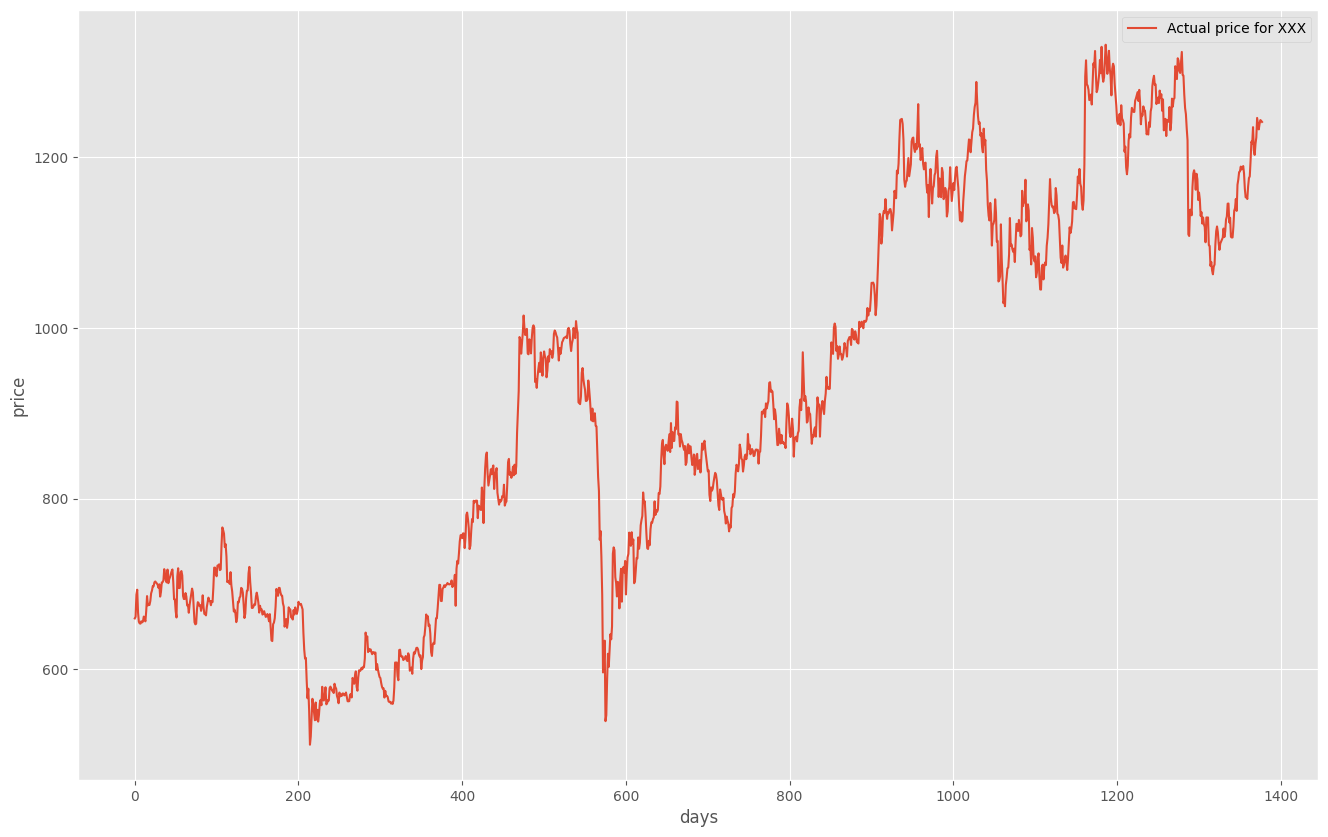

In [40]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['Close'])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [41]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['Close'] = init_df['Close'].astype(float)
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['Close'].values, axis=1))
init_df

,Date,Close,Volume,date,scaled_close
0,17-11-2017,659.549988,3200674,0,0.180438
1,20-11-2017,661.450012,712433,1,0.182755
2,21-11-2017,687.450012,2077453,2,0.214464
3,22-11-2017,693.150024,669175,3,0.221416
4,23-11-2017,666.299988,827451,4,0.188670
...,...,...,...,...,...
1373,09-06-2023,1232.400024,1904738,1373,0.879078
1374,12-06-2023,1238.900024,1402903,1374,0.887005
1375,13-06-2023,1243.300049,1253147,1375,0.892371
1376,14-06-2023,1242.300049,713768,1376,0.891152


In [42]:
# def PrepareData(days):
#   df = init_df.copy()
#   df['future'] = df['scaled_close'].shift(-days)
#   last_sequence = np.array(df[['scaled_close']].tail(days))
#   df.dropna(inplace=True)
#   sequence_data = []
#   sequences = deque(maxlen=N_STEPS)

#   for entry, target in zip(df[['scaled_close'] + ['Date']].values, df['future'].values):
#       sequences.append(entry)
#       if len(sequences) == N_STEPS:
#           sequence_data.append([np.array(sequences), target])

#   last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
#   last_sequence = np.array(last_sequence).astype(np.float32)

#   # construct the X's and Y's
#   X, Y = [], []
#   for seq, target in sequence_data:
#       X.append(seq)
#       Y.append(target)

#   # convert to numpy arrays
#   X = np.array(X)
#   Y = np.array(Y)

#   return df, last_sequence, X, Y




def PrepareData(days):
    df = init_df.copy()
    df['future'] = df['scaled_close'].shift(-days)
    last_sequence = np.array(df[['scaled_close']].tail(days))
    df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)
    
    for entry, target in zip(df[['scaled_close', 'Date']].values, df['future'].values):
        sequences.append(entry[:-1])  # Append only the scaled_close value, ignoring Date
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])
    
    last_sequence = list([s[:1] for s in sequences]) + list(last_sequence)  # Only take the scaled_close part
    last_sequence = np.array(last_sequence).astype(np.float32)
    
    # Construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)
    
    # Convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    
    return df, last_sequence, X, Y


In [43]:
PrepareData(3) # 3 days

(            Date        Close   Volume  date  scaled_close    future
 0     17-11-2017   659.549988  3200674     0      0.180438  0.221416
 1     20-11-2017   661.450012   712433     1      0.182755  0.188670
 2     21-11-2017   687.450012  2077453     2      0.214464  0.175742
 3     22-11-2017   693.150024   669175     3      0.221416  0.173303
 4     23-11-2017   666.299988   827451     4      0.188670  0.172998
 ...          ...          ...      ...   ...           ...       ...
 1370  06-06-2023  1223.000000   793761  1370      0.867614  0.879078
 1371  07-06-2023  1245.800049  1067618  1371      0.895420  0.887005
 1372  08-06-2023  1238.900024   760962  1372      0.887005  0.892371
 1373  09-06-2023  1232.400024  1904738  1373      0.879078  0.891152
 1374  12-06-2023  1238.900024  1402903  1374      0.887005  0.889688
 
 [1375 rows x 6 columns],
 array([[0.8426123 ],
        [0.858345  ],
        [0.86761385],
        [0.89542043],
        [0.88700527],
        [0.879078  ],


In [44]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [45]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

C:\Users\TRINADH\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0447
Epoch 2/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040
Epoch 3/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031
Epoch 4/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 5/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 6/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 7/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 8/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Epoch 9/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 10/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 11/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018
Epoch 12/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 13/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 14/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020
Epoch 15/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


C:\Users\TRINADH\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0262
Epoch 2/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040
Epoch 3/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 4/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 5/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029
Epoch 6/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028
Epoch 7/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 8/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 9/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 10/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 11/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 12/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 13/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 14/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 15/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


C:\Users\TRINADH\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0395
Epoch 2/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045
Epoch 3/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040
Epoch 4/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041
Epoch 5/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042
Epoch 6/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030
Epoch 7/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031
Epoch 8/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028
Epoch 9/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 10/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026
Epoch 11/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026
Epoch 12/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023
Epoch 13/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027
Epoch 14/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023
Epoch 15/80
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - l

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


In [46]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d) for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

  
  
  
  
  
  
  ext_list = [float(i) for i in predictions_list]

XXX prediction for upcoming 3 days (1264.6, 1227.87, 1249.99)


In [47]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [48]:
copy_df

,Date,Close,Volume,date,scaled_close,predicted_close
0,17-11-2017,659.549988,3200674,0,0.180438,654.900024
1,20-11-2017,661.450012,712433,1,0.182755,655.900024
2,21-11-2017,687.450012,2077453,2,0.214464,661.750000
3,22-11-2017,693.150024,669175,3,0.221416,659.099976
4,23-11-2017,666.299988,827451,4,0.188670,656.099976
...,...,...,...,...,...,...
1373,09-06-2023,1232.400024,1904738,1373,0.879078,1242.335083
1374,12-06-2023,1238.900024,1402903,1374,0.887005,1246.167725
1375,13-06-2023,1243.300049,1253147,1375,0.892371,1243.300049
1376,14-06-2023,1242.300049,713768,1376,0.891152,1242.300049


In [49]:
# # Add predicted results to the table
# # date_now = dt.date.today() - dt.timedelta(days=1)
# # date_tomorrow = dt.date.today()
# # date_after_tomorrow = dt.date.today() + dt.timedelta(days=1)

# # copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
# # copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
# # copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]




# # Define dates
# # date_now = dt.date.today()
# # date_tomorrow = dt.date.today() + dt.timedelta(days=1)
# # date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

# today = dt.date(2023, 6, 15)
# date_now = today.strftime('%Y-%m-%d')
# date_3_years_back = (today - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

# # Ensure the column names match exactly
# columns = ['Date', 'Close', 'Volume', 'date']

# # Create the new rows with the correct number of elements
# row_now = pd.DataFrame([[f'{date_now}', predictions[0], 0, f'{date_now}']], columns=columns, index=[date_now])
# row_tomorrow = pd.DataFrame([[f'{date_tomorrow}', predictions[1], 0, f'{date_tomorrow}']], columns=columns, index=[date_tomorrow])
# row_after_tomorrow = pd.DataFrame([[f'{date_after_tomorrow}', predictions[2], 0, f'{date_after_tomorrow}']], columns=columns, index=[date_after_tomorrow])

# # Concatenate the new rows to the existing DataFrame
# copy_df = pd.concat([copy_df, row_now, row_tomorrow, row_after_tomorrow])

# print(date_now)

# print(copy_df)







import datetime as dt
import pandas as pd

# Sample predictions list for demonstration
predictions = [110, 112, 115]

# Create the initial date
today = dt.date(2023, 6, 16)
date_now = today.strftime('%Y-%m-%d')

# Convert the string back to a datetime object
date_now_dt = dt.datetime.strptime(date_now, '%Y-%m-%d')

# Calculate future dates
date_tomorrow = date_now_dt + dt.timedelta(days=1)
date_after_tomorrow = date_now_dt + dt.timedelta(days=2)

# Format future dates to string
date_tomorrow_str = date_tomorrow.strftime('%Y-%m-%d')
date_after_tomorrow_str = date_after_tomorrow.strftime('%Y-%m-%d')

# Ensure the column names match exactly
columns = ['Date', 'Close', 'Volume', 'date']

# Create the new rows with the correct number of elements
row_now = pd.DataFrame([[date_now, predictions[0], 0, date_now]], columns=columns, index=[date_now])
row_tomorrow = pd.DataFrame([[date_tomorrow_str, predictions[1], 0, date_tomorrow_str]], columns=columns, index=[date_tomorrow_str])
row_after_tomorrow = pd.DataFrame([[date_after_tomorrow_str, predictions[2], 0, date_after_tomorrow_str]], columns=columns, index=[date_after_tomorrow_str])

# Concatenate the new rows to the existing DataFrame
copy_df = pd.concat([copy_df, row_now, row_tomorrow, row_after_tomorrow])

# Print the results
print(date_now)
print(copy_df)
print(init_df)


2023-06-16
                  Date        Close   Volume        date  scaled_close  \
0           17-11-2017   659.549988  3200674           0      0.180438   
1           20-11-2017   661.450012   712433           1      0.182755   
2           21-11-2017   687.450012  2077453           2      0.214464   
3           22-11-2017   693.150024   669175           3      0.221416   
4           23-11-2017   666.299988   827451           4      0.188670   
...                ...          ...      ...         ...           ...   
1376        14-06-2023  1242.300049   713768        1376      0.891152   
1377        15-06-2023  1241.099976   738348        1377      0.889688   
2023-06-16  2023-06-16   110.000000        0  2023-06-16           NaN   
2023-06-17  2023-06-17   112.000000        0  2023-06-17           NaN   
2023-06-18  2023-06-18   115.000000        0  2023-06-18           NaN   

            predicted_close  
0                654.900024  
1                655.900024  
2         

C:\Users\TRINADH\AppData\Local\Temp\ipykernel_16012\381014023.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  copy_df['Date'] = pd.to_datetime(copy_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\TRINADH\AppData\Local\Temp\ipykernel_16012\381014023.py:22: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  copy_df['Date'] = pd.to_datetime(copy_df['Date'], errors='coerce', infer_datetime_format=True)
C:\Users\TRINADH\AppData\Local\Temp\ipykernel_16012\381014023.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  copy_df['Date'].fillna(method='ffill', i

Found 3 unparseable dates. Filling with previous values.


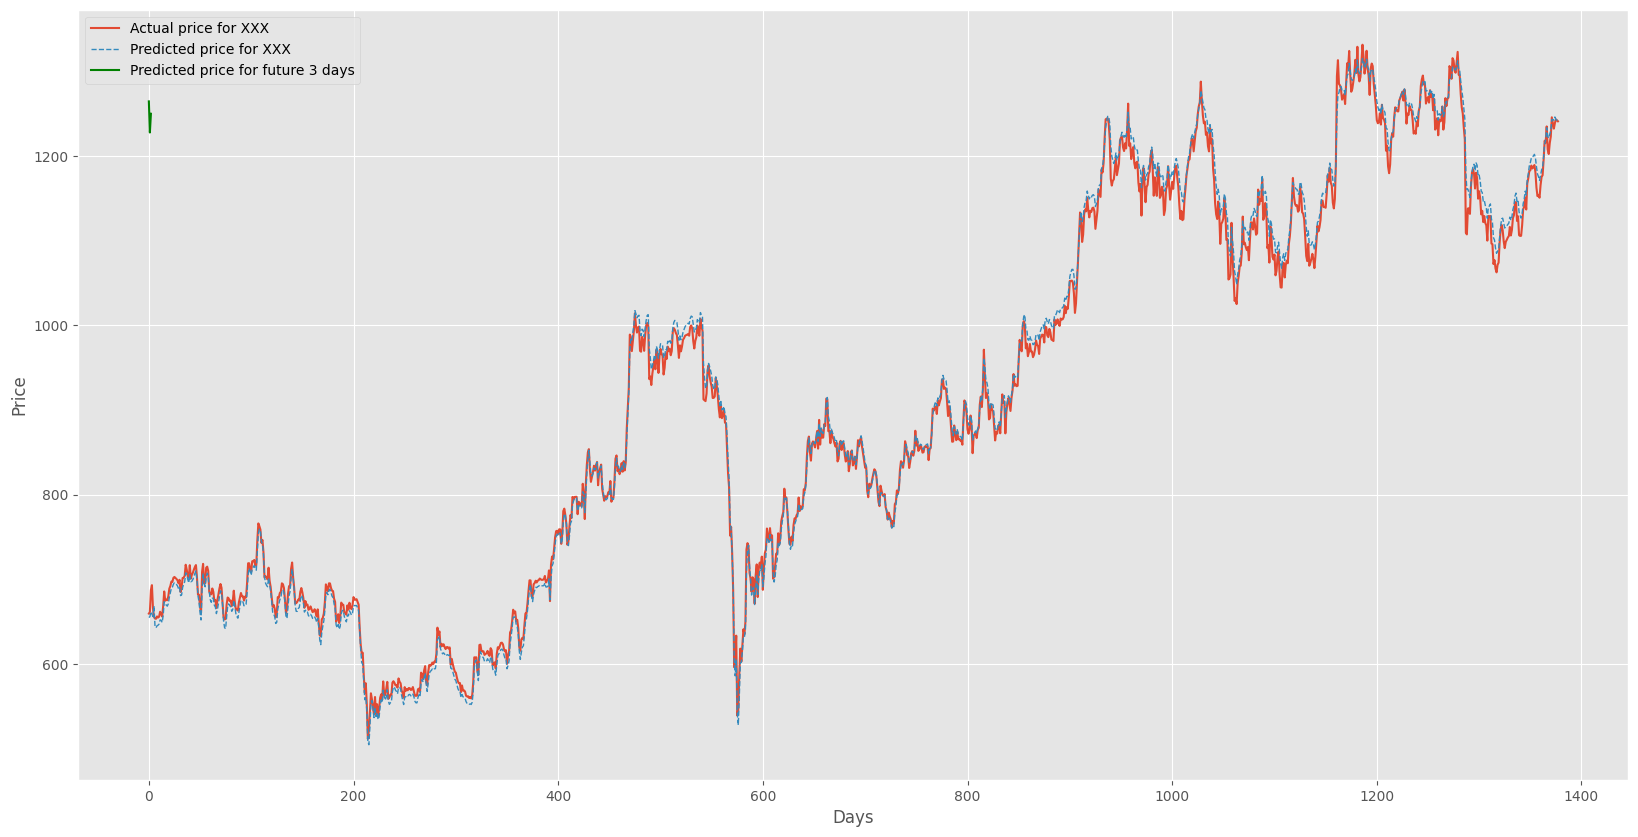

1371          1243.238770
1372          1243.087646
1373          1242.335083
1374          1246.167725
1375          1243.300049
1376          1242.300049
1377          1241.099976
2023-06-16            NaN
2023-06-17            NaN
2023-06-18            NaN
Name: predicted_close, dtype: float64
[1264.6, 1227.87, 1249.99]


In [50]:
# # Result chart
# plt.style.use(style='ggplot')
# plt.figure(figsize=(16,10))
# plt.plot(copy_df['close '][-150:].head(147))
# plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
# plt.plot(copy_df['close '][-150:].tail(4))
# plt.xlabel('days')
# plt.ylabel('price')
# plt.legend([f'Actual price for {STOCK}',
#             f'Predicted price for {STOCK}',
#             f'Predicted price for future 3 days'])
# plt.show()

# print(copy_df['predicted_close'][-10:].values)


from turtle import color
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Date' is converted to datetime format, handling mixed formats
copy_df['Date'] = pd.to_datetime(copy_df['Date'], errors='coerce', infer_datetime_format=True)

# Check for any NaT values and handle them
if copy_df['Date'].isna().sum() > 0:
    print(f"Found {copy_df['Date'].isna().sum()} unparseable dates. Filling with previous values.")
    copy_df['Date'].fillna(method='ffill', inplace=True)


ext_list = [float(i) for i in predictions_list]
ext_list


# Set the plot style
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))

# Plot actual close prices
plt.plot(init_df['Close'], label=f'Actual price for {STOCK}')

# # Plot predicted close prices
plt.plot(copy_df['predicted_close'].values, linewidth=1, linestyle='dashed', label=f'Predicted price for {STOCK}')

# Plot future predicted prices
# plt.plot(copy_df['predicted_close'][-3:].values, label=f'Predicted price for future 3 days')

plt.plot(ext_list, color='green', label=f'Predicted price for future 3 days')

# Set labels and legend
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()  

print(copy_df['predicted_close'].tail(10))                                                      
print(ext_list)







# import pandas as pd
# import matplotlib.pyplot as plt
# import datetime as dt

# # Define dates
# date_now = dt.date.today() - dt.timedelta(days=2)
# date_tomorrow = dt.date.today() - dt.timedelta(days=1)
# date_after_tomorrow = dt.date.today()

# # Ensure the Date column is in datetime format and clean non-date entries
# copy_df['Date '] = pd.to_datetime(copy_df['Date '], errors='coerce')
# copy_df = copy_df.dropna(subset=['Date '])

# # Create a new column for predicted close if it doesn't exist
# if 'predicted_close' not in copy_df.columns:
#     copy_df['predicted_close'] = None

# # Fill the 'predicted_close' column with predictions
# copy_df.loc[date_now, 'predicted_close'] = predictions[0]
# copy_df.loc[date_tomorrow, 'predicted_close'] = predictions[1]
# copy_df.loc[date_after_tomorrow, 'predicted_close'] = predictions[2]

# # Plot the data
# plt.style.use('ggplot')
# plt.figure(figsize=(16,10))
# plt.plot(copy_df['close '][-100:].head(147))
# plt.plot(copy_df['predicted_close'][-100:].head(147), linewidth=1, linestyle='dashed')
# plt.plot(copy_df['close '][-100:].tail(4))
# plt.xlabel('days')
# plt.ylabel('price')
# plt.legend([f'Actual price for {STOCK}',
#             f'Predicted price for {STOCK}',
#             f'Predicted price for future 3 days'])
# plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure the actual values are aligned with the predicted values
# Assuming init_df['Close'] contains the actual close prices and copy_df['predicted_close'] contains the predicted prices

# Align the actual and predicted values (exclude the first 6 and last 3 if needed)
actual_values = init_df['Close']
predicted_values = copy_df['predicted_close']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R²)
r2 = r2_score(actual_values, predicted_values)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


ValueError: Found input variables with inconsistent numbers of samples: [1378, 1381]

In [52]:
import numpy as np

# Ensure the actual values are aligned with the predicted values
# Assuming init_df['Close'] contains the actual close prices and copy_df['predicted_close'] contains the predicted prices

# Align the actual and predicted values (excluding the first 6 and last 3 if needed)
actual_values = init_df['Close']
predicted_values = copy_df['predicted_close']

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# Calculate accuracy as (100 - MAPE)
accuracy = 100 - mape

# Print the MAPE and accuracy
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"Accuracy: {accuracy}%")


Mean Absolute Percentage Error (MAPE): 1.0835431561031366%
Accuracy: 98.91645684389687%
